<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/project/07nov2021/TimeSeriesSplit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [166]:
!pip install yfinance
!pip install pandas-ta==0.2.45b

In [187]:
!pip install colorama

In [188]:
import yfinance as yf
import pandas_ta as ta
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report,f1_score

from colorama import Fore, Back, Style
import seaborn as sns
import plotly.express as px
import matplotlib
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
plt.style.use('fivethirtyeight')
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

In [189]:
def plot_cv_indices(cv, n_splits, X, y, date_col = None):
    """Create a sample plot for indices of a cross-validation object."""
    
    fig, ax = plt.subplots(1, 1, figsize = (11, 7))
    
    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)


    # Formatting
    yticklabels = list(range(n_splits))
    
    if date_col is not None:
        tick_locations  = ax.get_xticks()
        tick_dates = [" "] + date_col.iloc[list(tick_locations[1:-1])].astype(str).tolist() + [" "]

        tick_locations_str = [str(int(i)) for i in tick_locations]
        new_labels = ['\n\n'.join(x) for x in zip(list(tick_locations_str), tick_dates) ]
        ax.set_xticks(tick_locations)
        ax.set_xticklabels(new_labels)
    
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.2, -.2])
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
              ['Testing set', 'Training set'], loc=(1.02, .8))
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
           


In [168]:
data_for_modeling=yf.download('^nsei',start='2015-01-01',parse_dates=['Date']).reset_index()

[*********************100%***********************]  1 of 1 completed


In [169]:
data_for_modeling.ta.macd(append=True)
data_for_modeling.ta.vortex(append=True)
print()

In [170]:
#data_for_modeling.rename(columns={'date':'Date'},inplace=True)

In [171]:
features=data_for_modeling.columns.tolist()

In [172]:
features

['date',
 'open',
 'high',
 'low',
 'close',
 'adj_close',
 'volume',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'VTXP_14',
 'VTXM_14']

In [173]:
data_for_modeling['Signal']=data_for_modeling['close'].transform(lambda x : np.sign(x.diff(14)))


In [174]:
data_for_modeling=data_for_modeling.dropna()

In [175]:
X=data_for_modeling[features]
y=data_for_modeling['Signal']

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]


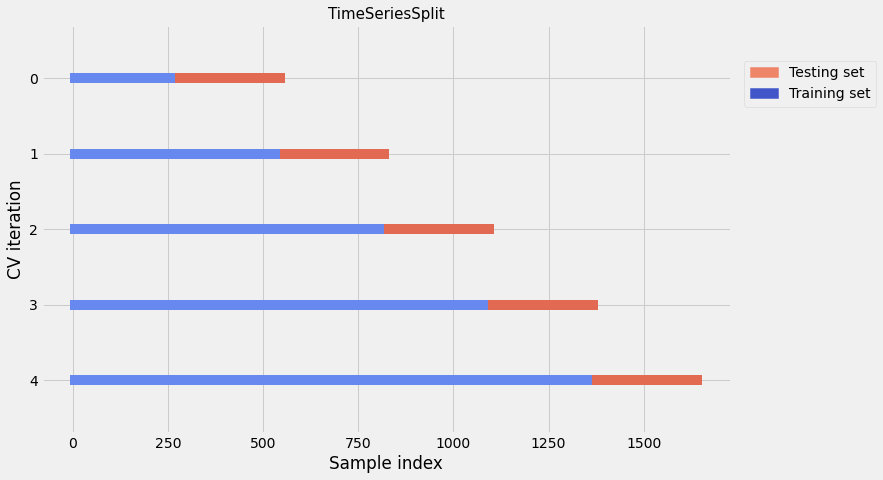

In [190]:
plot_cv_indices(tscv,5, X, y)

In [194]:

for train_index, test_index in tscv.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    print("Train Start: %d -> End %d" % (train_index[0], train_index[-1]))
    print("Test Start: %d -> End %d" % (test_index[0], test_index[-1]))
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)
    print("#" * 50)

Train Start: 0 -> End 276
Test Start: 277 -> End 550
(277, 12) (277,)
(274, 12) (274,)
##################################################
Train Start: 0 -> End 550
Test Start: 551 -> End 824
(551, 12) (551,)
(274, 12) (274,)
##################################################
Train Start: 0 -> End 824
Test Start: 825 -> End 1098
(825, 12) (825,)
(274, 12) (274,)
##################################################
Train Start: 0 -> End 1098
Test Start: 1099 -> End 1372
(1099, 12) (1099,)
(274, 12) (274,)
##################################################
Train Start: 0 -> End 1372
Test Start: 1373 -> End 1646
(1373, 12) (1373,)
(274, 12) (274,)
##################################################


In [195]:
rf=RandomForestClassifier()

In [196]:
rand_frst_clf = RandomForestClassifier(n_estimators = 200,max_depth=20,min_samples_leaf=3,max_features = "auto",min_samples_split=40, criterion = "gini", bootstrap=True,random_state = 42)

In [197]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(rand_frst_clf, X, y, cv= tscv, scoring="accuracy")
print(f'Scores for each fold are: {score}')
print(f'Average score: {"{:.2f}".format(score.mean())}')


Scores for each fold are: [nan nan nan nan nan]
Average score: nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion




In [200]:
from sklearn.model_selection import cross_validate

cross_validate(rand_frst_clf, X, y, cv= tscv, scoring="accuracy")

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
TypeError: invalid type promotion




{'fit_time': array([0.00370359, 0.00241423, 0.00206518, 0.00304937, 0.00149632]),
 'score_time': array([0., 0., 0., 0., 0.]),
 'test_score': array([nan, nan, nan, nan, nan])}